## Implémentez un modèle de scoring pour attribution de Crédit : 

### opt_hyperparametres (RandomizedSearchCV) & weight_class & feature importances

## Data model
La structure des données est expliquée dans l'image suivante (à partir de la description des données sur la page Kaggle)

![Image of Home credit](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

"application_train/test.csv" contient le prêt et les demandeurs de prêt. 

"bureau.csv" contient les données d'autres prêts que le client a contractés auprès d'autres établissements de crédit. 

"previous_applications.csv" contient des informations sur les prêts précédents chez la société "Prêt à dépenser" par le même client, des informations sur les prêts précédents et des informations sur le client au moment du prêt (il y a une ligne dans la trame de données par demande de prêt précédente).

"SK_ID_CURR" connecte les dataframes "application_train|test.csv" avec "bureau.csv", "previous_application.csv" et aussi avec les dataframes "POS_CASH_balance.csv", "instalment_payments.csv" et "credit_card_balance.csv". 

"SK_ID_PREV" connecte la trame de données  "previous_application.csv" avec "POS_CASH_balance.csv", "instalment_payments.csv" et "credit_card_balance.csv". 

"SK_ID_BUREAU" connecte la dataframe "bureau.csv" avec dataframe "bureau_balance.csv".

## Chargement des données :
Une fonction par fichier qui assure les traitements suivants :

. Chargement des données

. Fusion des fichiers

. Encodage des variables catégorielles ( OneHotEncoding/Encodage binaire)

. Traitement des valeurs manquantes

In [1]:
# import library 
import numpy as np
from numpy import isnan
import pandas as pd
import gc

import time
from contextlib import contextmanager
import matplotlib.pyplot as plt
import re
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import  train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold


from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import *
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from numpy import mean
from scipy.stats import uniform as sp_randFloat

from sklearn.model_selection import learning_curve

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from collections import Counter
from numpy import where
from scipy.stats import randint as sp_randint

%matplotlib inline

In [17]:
###############################################################################################################################
#==================================================== Fonctions ==============================================================#
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


def generate_model_report(Model, y_actual, y_predicted):
    
    precision, recall, fscore, support = precision_recall_fscore_support (y_actual, y_predicted) #score
    print("")
    print("Model :", Model)
    print("==============================================================================")
    print('Precision : {}'.format(precision))
    print('recall : {}'.format(recall))
    print('fscore : {}'.format(fscore))
    print('support : {}'.format(support))
    pass    

# Fonction d'évaludation des modèles (Learning Curve)
def evaluation (model , X_train, y_train,X_test,cv,width_fig,height_fig,scoring):
    
        model.fit(X_train, y_train)
        ypred = model.predict(X_test)
        N, train_score, val_score = learning_curve(model, X_train, y_train, cv=cv, scoring=scoring, 
                                               train_sizes=np.linspace(0.1,1,10))
        plt.figure(figsize=(width_fig,height_fig))
        plt.plot(N,-train_score.mean(axis=1), label = "Train score")
        plt.plot(N,-val_score.mean(axis=1), label = "Val score")
        plt.title("Learning Curve :")
        plt.legend()
        plt.show()

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
        
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + 
           " columns. There are " + str(mis_val_table_ren_columns.shape[0]) +
           " columns that have missing values")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns


def missing_values_density(df):    
    # densité des colonnes avec valeurs manquantes : 
    nan_values = df.isnull().sum()
    nan_values = nan_values / df.shape[0] *100

    plt.figure(figsize=(20,8))
    sns.distplot(nan_values, kde=False, bins=int(df.shape[0]/1000), color = "Red")
    #sns.distplot(nan_values, kde=False, bins=np.int(df.shape[0]/1000), color = "Red")
    plt.xlabel("Percentage of nan_values", size = 15)
    plt.ylabel("Frequency", size = 15)
    plt.title("Missing values by feature", size = 20)
    
# densité des colonnes avec valeurs manquantes : 
def densite(D):
    return ((D.isnull().sum()/(D.shape[0]))*100).sort_values(ascending=False)
    
global prct_positif
def missing_values_imputation(df):
    for v in df.columns:
        #if (df[v].dtypes == 'float64' or df[v].dtypes == 'int64'): 
        median=df[v].median()
        df[v].fillna(median, inplace=True)
    
    print("Done : 100% \n")
    
            
def dropna(df):
    df=df.dropna(inplace=True)
            
            
# Function to reduce the size of the dataset using Principal Component Analysis (PCA):
def pca(X,y):
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    plot_2d_space(X, y, 'dataset (2 PCA components)')
    
            
# 2-dimensional plot function, plot_2d_space, to see the data distribution:           
def plot_2d_space(X, y, label='Classes'):   
    # Data display
    colors = ['#00CC00','#CC0000']
    for l, c in zip(np.unique(y), colors):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l
        )
    
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
    
    
def algorithms_evaluation(Algorithm):
    #df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    feat_importance = Algorithm(df, num_folds= 10, stratified= False, debug= debug)

In [3]:
# Fonction randomsearchCV avec un premier résultat d'hyperparamètres et performances des modèle   
best_models=[]
def Random_search (estimators,parameters, n_iter, cv,scoring, random_state, X_train_smt, y_train_smt):
    global name
    global elapsed_time,best_est,best_param,best_score
    global score 
    global final_model
    score=0
    best_estimators=[]
    for (name, est) in (estimators):
        start_time = time.time()
        # RandomizedSearchCV
        rnd_search = RandomizedSearchCV(est, param_distributions=parameters[name],
                                        n_iter=n_iter, cv=cv, scoring=scoring, 
                                        random_state=random_state,refit="roc_auc_score")
        # Entrainement du modèle sur les données d'entrainement
        rnd_search.fit(X_train_smt, y_train_smt,est__class_weight={0:0.95, 1:0.05})
        elapsed_time =(time.time() - start_time)/3600   
        best_est =rnd_search.best_estimator_
        best_param= rnd_search.best_params_
        best_score=rnd_search.best_score_
        best_estimators = best_estimators.append(best_est)
        # Appel de la Fonction d'affichage des résultats le la recherche aléaoire pour chaque modèle.
        Results_RandSearchCV (name,elapsed_time,best_est,best_param,best_score,scoring,best_estimators)

# Affichage des résultats de la recherche aléatoire des meilleurs hyperparamètres 
def Results_RandSearchCV (name,elapsed_time,best_est,best_param,best_score,scoring,best_estimators):
    print("")
    # Results from Random Search
    print("")
    # Results from Random Search
    print("===============================================================================================================================")    
    print("                                               Results from RandomizedSearchCV                                                ")
    print("===============================================================================================================================")        
    print(name,":","elapsed_time =", (r"{:.2f}").format(elapsed_time)," Hours")
    print("===============================================================")
    print("The best estimator across ALL searched params:\n", best_est)
    print("The best scoring =",scoring," ",(best_score).round(4),"\n")
    print("The best parameters across ALL searched params:\n", best_param)         
    print("============ Synthesis Best estimators =====================")
    print("Best estimators :",best_estimators)
    
    return best_estimators
    
    # fig.savefig('multiple_roc_curve.png')         

In [10]:
######################################################
##### ========Preprocessing functions ==========####
######################################################
imputation=['median','mean']
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('./input/application_train.csv', nrows= num_rows)
    print("application_train :",df.shape)
    test_df = pd.read_csv('./input/application_test.csv', nrows= num_rows)
    print("application_test:",test_df.shape)
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df=df[df['DAYS_EMPLOYED']!= 365243]
    #df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./input/bureau.csv', nrows = num_rows)
    print("bureau :",bureau.shape)
    bb = pd.read_csv('./input/bureau_balance.csv', nrows = num_rows)
    print("bureau_balance:",bb.shape)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./input/previous_application.csv', nrows = num_rows)
    print("previous_application:",prev.shape)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    #prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev=prev[prev['DAYS_FIRST_DRAWING']!= 365243]
    #prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev=prev[prev['DAYS_FIRST_DUE']!= 365243]
    #prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev=prev[prev['DAYS_LAST_DUE_1ST_VERSION']!= 365243]
    #prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev=prev[prev['DAYS_LAST_DUE']!= 365243]
    #prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    prev=prev[prev['DAYS_TERMINATION']!= 365243]
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./input/POS_CASH_balance.csv', nrows = num_rows)
    print("POS_CASH_balance:",pos.shape)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./input/installments_payments.csv', nrows = num_rows)
    print("installments_payments : ",ins.shape)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./input/credit_card_balance.csv', nrows = num_rows)
    print("credit_card_balance:",cc.shape)
    print("")
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# preprocessing :

                            Starting preprocessing........
application_train : (307511, 122)
application_test: (48744, 121)
bureau : (1716428, 17)
bureau_balance: (27299925, 3)
previous_application: (1670214, 37)
POS_CASH_balance: (10001358, 8)
installments_payments :  (13605401, 8)
credit_card_balance: (3840312, 23)

removing empty columns > 50% :
Done : 100%
Check missing values before imputation :
Your selected dataframe has 522 columns. There are 339 columns that have missing values
Missing values imputation processing :
Done : 100% 



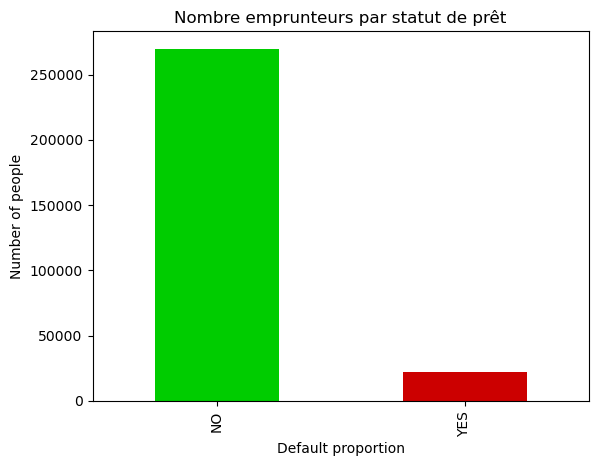

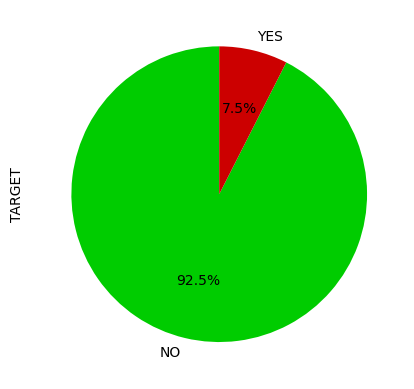

Imbalanced TARGET plot : reduction of dimmensions with PCA components


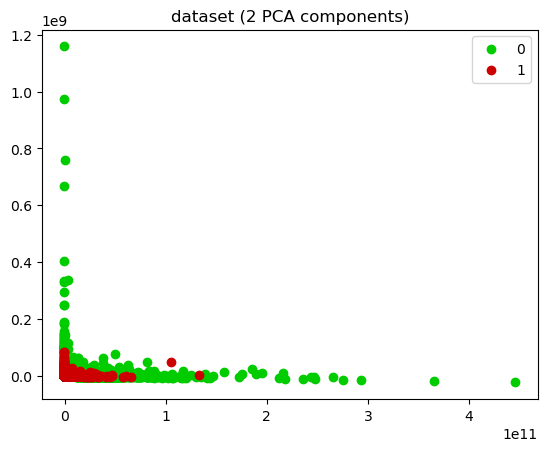

y_train shape: (204122,) y_train counter: Counter({0: 188838, 1: 15284})
y_test shape: (87481,) y_test counter: Counter({0: 80930, 1: 6551})


In [18]:
print("                            Starting preprocessing........")
print("=======================================================================================")
num_rows = 10000 if False else None
df = application_train_test(num_rows)
bureau = bureau_and_balance(num_rows)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
        
prev = previous_applications(num_rows)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
    
pos = pos_cash(num_rows)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos

ins = installments_payments(num_rows)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
   
cc = credit_card_balance(num_rows)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc
    
# replace infinity values by "nan"
df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
print("removing empty columns > 50% :")
print("=============================")
# removing empty columns > 50%
df = df.loc[:, df.isnull().mean() <.50]
print("Done : 100%")
    
# missing_values_imputation
print("Check missing values before imputation :")
print("=======================================")
missing_values_table(df)

    
print("Missing values imputation processing :")
print("=====================================")
missing_values_imputation(df)

# =================== Affichage Graphique du déséquilibre des classes ====================    
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = df['TARGET']
X_id=df['SK_ID_CURR']

import joblib
# Sauvegarde du modèle
joblib.dump(id, 'id.pkl')

X= df.drop(['index','TARGET', 'SK_ID_CURR'],axis=1)
y.replace(to_replace=[1,0], value= ['YES','NO'], inplace = True)
fig11=plt.figure()
ax11=plt.axes()
colors = ['#00CC00','#CC0000']
plt.title('Nombre emprunteurs par statut de prêt')
ax11 = ax11.set(xlabel='Default proportion', ylabel='Number of people')   
y.value_counts().plot.bar(color=colors)
fig12=plt.figure()
ax12=plt.axes()    
y.value_counts().plot.pie(startangle=90, autopct='%1.1f%%',colors=colors )
plt.show()
y.replace(to_replace=['YES','NO'], value=[1,0] , inplace = True)
print("Imbalanced TARGET plot : reduction of dimmensions with PCA components")
print("======================================================================")
pca(X,y)
# print("split de la partie test déséquilibrée en 2 pour tester le modèle (rapidité de traitement) :")
# print("==========================================================================================")
X_train_2 , X_test_2 , y_train_2, y_test_2= train_test_split(X,y,test_size=0.3, random_state=42,stratify=y)
counter_y_test_2=Counter(y_test_2)
counter_y_train_2=Counter(y_train_2)

print("y_train shape:", y_train_2.shape, "y_train counter:", counter_y_train_2)
print("y_test shape:", y_test_2.shape, "y_test counter:", counter_y_test_2)

In [12]:
X_train_2.shape, y_train_2.shape, X_test_2.shape, X_id.shape, y_test_2.shape

((204122, 519), (204122,), (87481, 519), (291603,), (87481,))

# modelisation :

In [13]:
print("========================================================================================================================")    
print("                                               hyperparameters optimization :")
print("                                               =============================")
print("                                               Results from RandomizedSearchCV                                                ")
print("========================================================================================================================")     

# ==================  Instanciation des différents modèles ===============================
LOGREG_clf = LogisticRegression() # solver='lbfgs', max_iter=500
RFC_clf= RandomForestClassifier()
DUMMY_clf = DummyClassifier()
LGBM_clf=LGBMClassifier()
################ estimators list used with for models performances analysis with default parameters #####################
estimators = [("DummyClassifier", DUMMY_clf),    
              ("LightGBM",LGBM_clf), 
              ("RandomForestClassifier", RFC_clf),              # 
              ("LogisticRegression", LOGREG_clf)                # 
             ]
################################## Hyperparameters used for RandomizedSearchCV ###############################################
weights=(np.linspace(10.0, 20.0, num = 3,dtype= float)) 

LOGREG_rand_params= [{'max_iter':sp_randint(500, 5000),
                      'C': np.logspace(-4, 4, 20),
                      'class_weight': [{0:1, 1:20}]   # 13=>0.38 ; 20=> 0.44      
                     }]
    
RFC_rand_params= [{'n_estimators' :[100,500],
                   'max_depth':[3,5,None],
                   'max_features':sp_randint(1,3),
                   'criterion':['gini'], # ,'entropy'   # Cost function
                   'bootstrap':[True,False],
                   'min_samples_leaf':sp_randint(1,4),
                   'class_weight': [{0:1, 1:20}]
                  }]

LGBM_rand_params=[{'nthread':[2,6],
                   'n_estimators':[300,700,1000],
                   'learning_rate':sp_randFloat(0.02,0.2),
                   'num_leaves':[30,35],
                   'max_depth':[5,10,15],
                   'min_child_weight':[35,40],
                   'scale_pos_weight': {0:1, 1:20}
                  }]
            
#XGBC_rand_params= [{'n_estimators':sp_randint(100, 500,1000),
#                    'learning_rate':sp_randFloat(0.05,0.1),
#                    'max_depth':sp_randint(5, 20),
#                    'scale_pos_weight': weights, #for x in weights],
#                    'objective':['binary:logistic']
#                  }]

Dummy_rand_params= [{'strategy':['stratified']
                    }]      
################################## Hyperparameters list used for RandomizedSearchCV ##################
params_list_RndSearchCV =  {'DummyClassifier': Dummy_rand_params,
                            'LightGBM':LGBM_rand_params,
                            #'XGradientBoostingClassifier': XGBC_rand_params,
                            'RandomForestClassifier': RFC_rand_params,
                            'LogisticRegression': LOGREG_rand_params
                           } 
######################## Utilisation de RandomizedSearchCV ##################################
# Appel de la fonction RandomizedSearchCV : inputs = (estimators,parameters, n_iter, cv,scoring, random_state)
acc = make_scorer(accuracy_score)
auc_score = make_scorer(roc_auc_score)
recall = make_scorer(recall_score)
F1=make_scorer(f1_score)
scoring = {"AUC": auc_score} 
score=0
model=[]
Names=[]
#====================== hyperparameters Optimisation======================== 
for (name, est) in (estimators):
    start_time = time.time()
    print("Model name : ", name)
    print("Statut : in progress......please wait")
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)    # n_splits=10, n_repeats=3
    # RandomizedSearchCV
    rnd_search = RandomizedSearchCV(est, param_distributions=params_list_RndSearchCV[name],
                                    n_iter=10, cv=cv, scoring=scoring, n_jobs=-1,    # Ajouter le class_weight et l'ajouter dans parm grid
                                    random_state=42,refit="AUC")    
    # Entrainement du modèle sur les données d'entrainement
    rnd_search.fit(X_train_2, y_train_2)
    print("Statut : Done")
    elapsed_time =(time.time() - start_time)/3600   
    best_est =rnd_search.best_estimator_
    # Appel de la fonction évaludation des modèles  (model , X_train, y_train,X_test,cv,scoring)
    #evaluation (best_est, X_train_2, y_train_2, X_test_2, 5, 15, 8, 'roc_auc') # neg_root_mean_squared_error      
    best_param= rnd_search.best_params_
    best_score=rnd_search.best_score_
    # best_estimators = best_estim.append(best_est)
    model.append(best_est)
    Names.append(name)
    print("RandomizedSearchCV elapsed_time =", (r"{:.2f}").format(elapsed_time)," Hours")
    print("AUC :",(best_score).round(4))
    print("\n The best estimator across ALL searched params:\n",best_est)
    print("\n")
    print("===============================================================================")

                                               hyperparameters optimization :
                                               Results from RandomizedSearchCV                                                
Model name :  DummyClassifier
Statut : in progress......please wait
Statut : Done
RandomizedSearchCV elapsed_time = 0.02  Hours
AUC : 0.4991

 The best estimator across ALL searched params:
 DummyClassifier(strategy='stratified')


Model name :  LightGBM
Statut : in progress......please wait
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=6 will be ignored. Current value: num_threads=-1
Statut : Done
RandomizedSearchCV elapsed_time = 1.00  Hours
AUC : 0.7046

 The best estimator across ALL searched params:
 LGBMClassifier(learning_rate=0.11009985039390861, max_depth=10,
               min_child_weight=40, n_estimators=300, nthread=6, num_leaves=35,
               scale_pos_weight=20)


Model name :  RandomForestClassifier
Statut : in progress......please wait
Statut : 

In [14]:
print("                     performance of the selected models ") 
print("                    =====================================")
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['models','fpr','tpr','F_beta_Score','fprOpt','tprOpt']) 
y_prediction=[]
conf_mat=[]
features=[]
start_time_models = time.time()
elapsed_time_all_models=0
fbeta_int=0
i=0
for Model in (model):
    nom_model=Names[i]
    start_time_model = time.time()
    
    # summarize performance
    prob = Model.predict_proba(X_test_2)
    y_pred= Model.predict(X_test_2)
    y_prediction.append(y_pred)
    prob = prob[:, 1]
    generate_model_report(Model, y_test_2, y_pred)
    
    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_2, prob)
    
    # Calculate the G-mean
    gmean=np.sqrt(tpr*(1-fpr))
    
    # Find the optimal threshold
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    gmeanOpt = round(gmean[index], ndigits = 4)
    fprOpt = round(fpr[index], ndigits = 4)
    tprOpt = round(tpr[index], ndigits = 4)
    
    # Auc Score
    #auc=auc(fpr, tpr, reorder=True)
    auc=roc_auc_score(y_test_2, prob)
    
    # F-beta score : 
    fbeta= fbeta_score(y_test_2, y_pred, beta=2.775)
    
    # Confusion Matrix
    cm=confusion_matrix(y_test_2, y_pred)
    conf_mat.append(cm)
    print("")
    print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
    print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))
    print("")
    print("Confusion Matrix :\n", cm)
    print("=================")
    print("")
    # Display results
    result_table = result_table.append({'models':Model.__class__.__name__, 
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'fprOpt':fprOpt,
                                        'tprOpt':tprOpt,
                                        #'auc':auc,
                                        'F_beta_Score':fbeta,
                                        'threshold':thresholdOpt}, ignore_index=True)
    
    elapsed_time_model =np.round((time.time() - start_time_model)/3600,2)
    print(Model,": 100% , Done in :",elapsed_time_model, "Hours")
    print("")
    # Save best model performances  
    ############## Sauvegarde du modèle le plus performant (RMSE la plus basse) ####################  
    if fbeta > fbeta_int :
        fbeta_int = fbeta
        final_model = Model   # Attribution du modèle entraîné à une variable
        Model_name=nom_model
        Optimal_threshold=thresholdOpt
    i=i+1
    ######################################################################################################################

                     performance of the selected models 

Model : DummyClassifier(strategy='stratified')
Precision : [0.92531858 0.07742035]
recall : [0.92593599 0.07678217]
fscore : [0.92562718 0.07709994]
support : [80930  6551]

Best Threshold: 1.0 with G-Mean: 0.2654
FPR: 0.0751, TPR: 0.0762

Confusion Matrix :
 [[74936  5994]
 [ 6048   503]]

DummyClassifier(strategy='stratified') : 100% , Done in : 0.0 Hours


Model : LGBMClassifier(learning_rate=0.11009985039390861, max_depth=10,
               min_child_weight=40, n_estimators=300, nthread=6, num_leaves=35,
               scale_pos_weight=20)
Precision : [0.96993367 0.15802872]
recall : [0.68123069 0.7391238 ]
fscore : [0.8003426  0.26038558]
support : [80930  6551]

Best Threshold: 0.5195 with G-Mean: 0.7121
FPR: 0.2983, TPR: 0.7228

Confusion Matrix :
 [[55132 25798]
 [ 1709  4842]]

LGBMClassifier(learning_rate=0.11009985039390861, max_depth=10,
               min_child_weight=40, n_estimators=300, nthread=6, num_leaves=35,


In [15]:
result_table

models                                                fpr  \
0         DummyClassifier                    [0.0, 0.07507722723341159, 1.0]   
1          LGBMClassifier  [0.0, 1.2356357345854442e-05, 1.23563573458544...   
2  RandomForestClassifier  [0.0, 0.0, 0.0, 2.4712714691708883e-05, 2.4712...   
3      LogisticRegression  [0.0, 1.2356357345854442e-05, 0.00013591993080...   

                                                 tpr  F_beta_Score  fprOpt  \
0                    [0.0, 0.07617157685849489, 1.0]      0.076855  0.0751   
1  [0.0, 0.0, 0.0007632422530911311, 0.0007632422...      0.519547  0.2983   
2  [0.0, 0.00015264845061822624, 0.00122118760494...      0.431153  0.3320   
3  [0.0, 0.0, 0.0, 0.00015264845061822624, 0.0001...      0.416918  0.5447   

   tprOpt  threshold  
0  0.0762     1.0000  
1  0.7228     0.5195  
2  0.6452     0.4811  
3  0.5715     0.5687

ALL Models evaluation Done in : 0.0 Hours


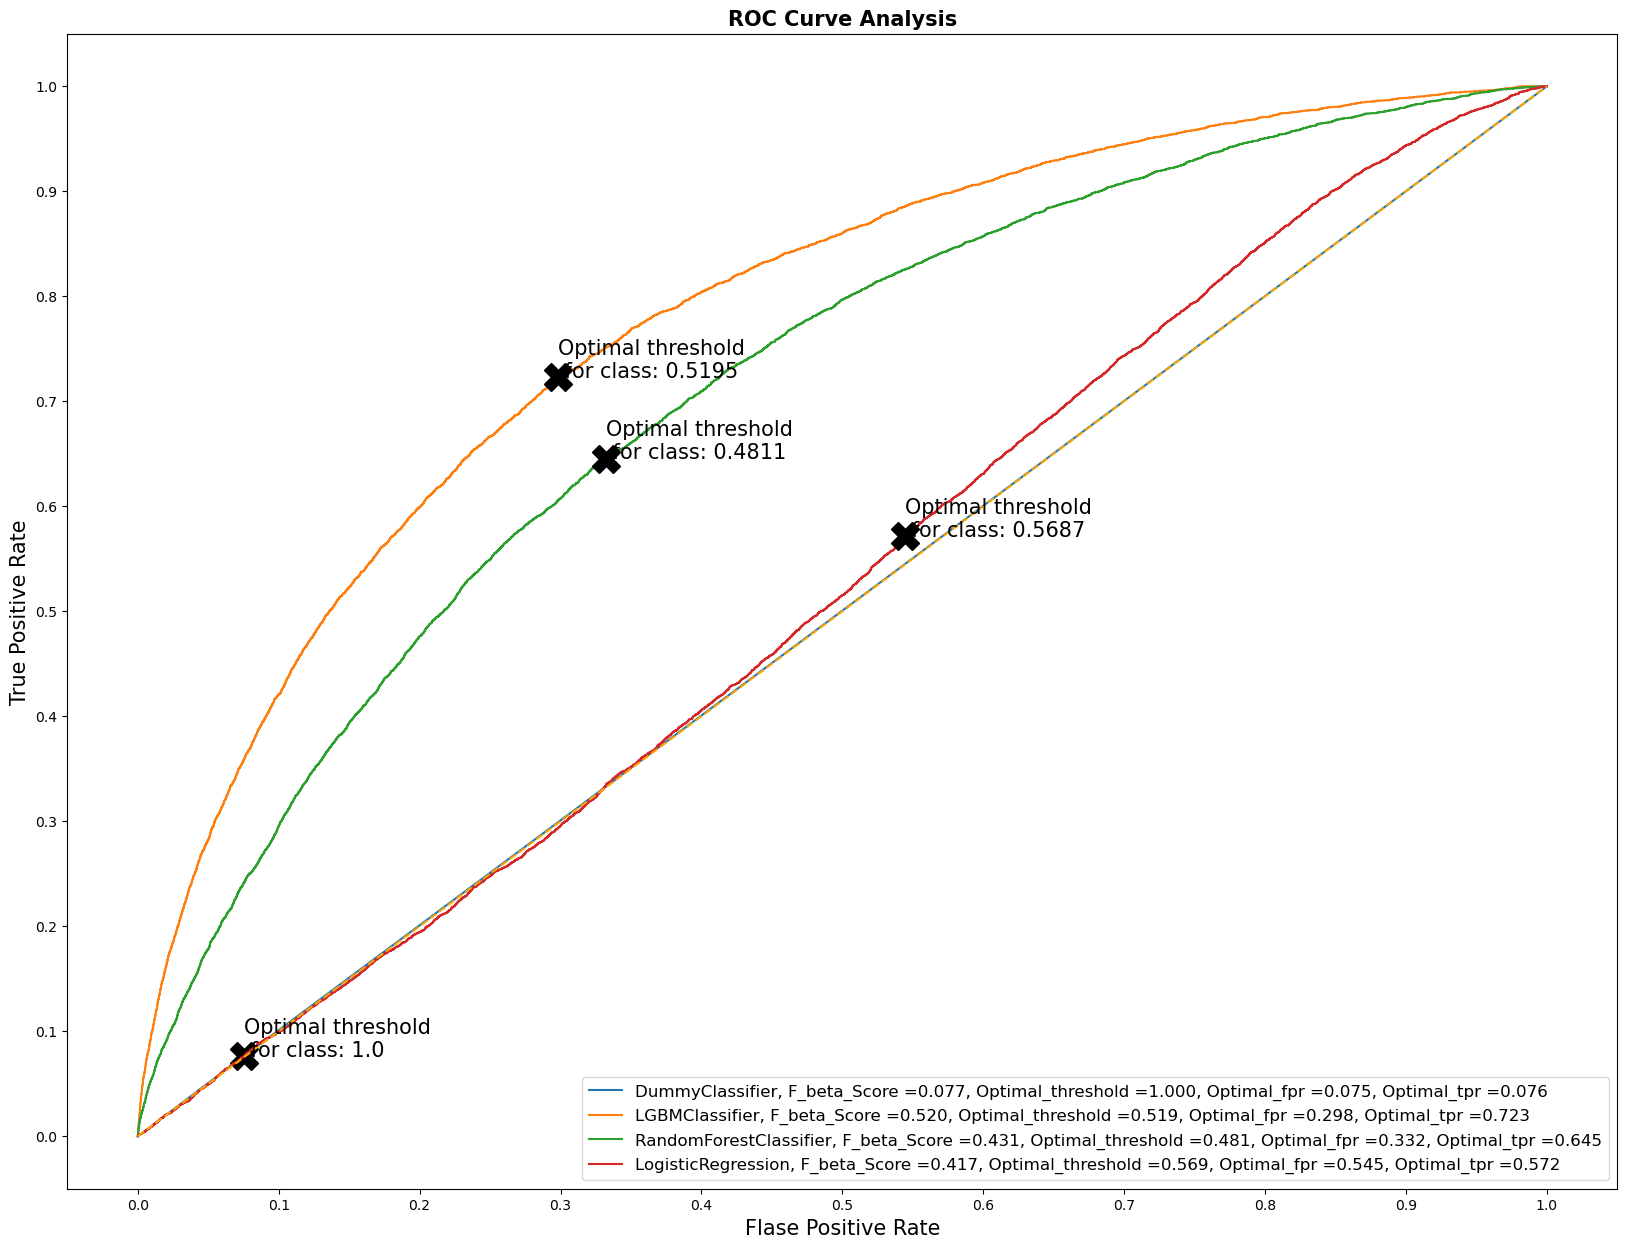

                 According to business requirements, the best Model is : 

Final Model name : LightGBM

Final model Optimal_threshold : 0.5195

Final Model hyperparameters :
LGBMClassifier(learning_rate=0.11009985039390861, max_depth=10,
               min_child_weight=40, n_estimators=300, nthread=6, num_leaves=35,
               scale_pos_weight=20)


In [16]:
elapsed_time_all_models = elapsed_time_all_models + elapsed_time_model
print("ALL Models evaluation Done in :",elapsed_time_all_models, "Hours") 

fig = plt.figure(figsize=(20,15))
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, F_beta_Score ={:.3f}, Optimal_threshold ={:.3f}, Optimal_fpr ={:.3f}, Optimal_tpr ={:.3f}".format(result_table.loc[i]['models'], float(result_table.loc[i]['F_beta_Score']), float(result_table.loc[i]['threshold']), float(result_table.loc[i]['fprOpt']), float(result_table.loc[i]['tprOpt'])))
    plt.plot(result_table.loc[i]['fprOpt'],result_table.loc[i]['tprOpt'],marker="X",markersize=20, color='black')
    plt.text(result_table.loc[i]['fprOpt'],result_table.loc[i]['tprOpt'], 'Optimal threshold \n for class: {}'.format(result_table.loc[i]['threshold']), fontsize=15)
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
             
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':12}, loc='lower right')
plt.show()

print("===============================================================================================================================")    
print("                 According to business requirements, the best Model is : \n"                 )
print("===============================================================================================================================")        
print("Final Model name :", Model_name)
print("=================")
print("")
print("Final model Optimal_threshold :", Optimal_threshold)
print("=============================")
print("")
print("Final Model hyperparameters :")
print("============================")
print(final_model)


# fig.savefig('multiple_roc_curve.png')

In [19]:
import joblib
# Sauvegarde du modèle
joblib.dump(final_model, 'scoring_credit_model.pkl')
# Sauvegarde du seuil
joblib.dump(Optimal_threshold, 'threshold_model.pkl')
# Sauvegarde du seuil
joblib.dump(X, 'X.pkl')

['X.pkl']

In [20]:
# Sauvegarde de df
joblib.dump(df, 'df.csv')

['df.csv']

In [21]:
X_train_2.shape, X_test_2.shape, y_train_2.shape

((204122, 519), (87481, 519), (204122,))

In [22]:
# Sauvegarde du dataset sous forme de dictionnaire:
dict_cleaned = {'X_train': X_train_2,
                'y_train': y_train_2,
                'y_test': y_test_2,
                'X_test': X_test_2,
                'id': X_id,
                'X':X,
                'y':y}

In [23]:
import dill

with open('dict_cleaned.pkl', 'wb') as file:
    dill.dump(dict_cleaned, file)

In [24]:
def plot_sankey_confusion_mat(cm, static=False, figsize=(2, 1.7),
                              font_size=14, scale=1, title=None,
                              palette='tab10'):

    n_cat = cm.shape[0]
    n_clust = cm.shape[1]
    source = np.array([n_clust*[i] for i in range(n_cat)]).ravel()
    target = np.array([[i] for i in range(n_cat, n_clust+n_cat)]*n_cat).ravel()
    value = cm.values.ravel()
    nodes_lab = list(cm.index)+list(cm.columns)
    alpha_nodes, alpha_links = 0.7, 0.3
    my_pal = sns.color_palette(palette, max(cm.shape))
    pal_nodes_cat = list([f'rgba({r},{g},{b},{alpha_nodes})'
                          for r, g, b in my_pal[:n_cat]])
    pal_nodes_clust = list([f'rgba({r},{g},{b},{alpha_nodes})'
                            for r, g, b in my_pal[:n_clust]])
    nodes_colors = (pal_nodes_cat + pal_nodes_clust)

    pal_links = list([f'rgba({r},{g},{b},{alpha_links})' for r, g, b in my_pal[:n_cat]])
    dict_links_colors = dict(zip(range(n_cat), pal_links))
    links_colors = np.vectorize(dict_links_colors.__getitem__)(source)

    # Prepare the graph
    fig = go.Figure(data=[go.Sankey(node=dict(pad=15,
                                              thickness=20,
                                              line=dict(color="black",
                                                        width=0.5),
                                              label=nodes_lab,
                                              color=nodes_colors),
                                    link=dict(source=source,
                                              target=target,
                                              value=value,  # label = ,
                                              color=links_colors))])
    # title
    fig.update_layout(title_text=title, font_size=font_size)
    if static:
        w, h = figsize
        img_bytes = fig.to_image(format="png", width=w, height=h, scale=scale)
        # Image(img_bytes)
        return img_bytes
    else:
        fig.show()

## Feature importance :

### Global Explanation

In [25]:
## interprétation des variables locales :
# Chargement du model de prédiction :
Scoring_credit = joblib.load('scoring_credit_model.pkl')
threshold=joblib.load('threshold_model.pkl')

features  weights
213                    PAYMENT_RATE      263
30                     EXT_SOURCE_2      249
31                     EXT_SOURCE_3      218
29                     EXT_SOURCE_1      215
9                        DAYS_BIRTH      195
12                  DAYS_ID_PUBLISH      151
6                       AMT_ANNUITY      144
11                DAYS_REGISTRATION      144
210              INCOME_CREDIT_PERC      139
49           DAYS_LAST_PHONE_CHANGE      135
498                 INSTAL_DBD_MEAN      133
212             ANNUITY_INCOME_PERC      129
511          INSTAL_AMT_PAYMENT_MIN      122
516  INSTAL_DAYS_ENTRY_PAYMENT_MEAN      120
10                    DAYS_EMPLOYED      120
8        REGION_POPULATION_RELATIVE      118
5                        AMT_CREDIT      112
515   INSTAL_DAYS_ENTRY_PAYMENT_MAX      112
209              DAYS_EMPLOYED_PERC      112
235    BURO_MONTHS_BALANCE_SIZE_SUM      106
7                   AMT_GOODS_PRICE      105
497                  INSTAL_DBD_MAX      103
477         POS_MONTHS_BALANCE_SIZE      102
211               INCOME_PER_PERSON       98
499                  INSTAL_DBD_SUM       97
268  ACTIVE_DAYS_CREDIT_UPDATE_MEAN       96
263          ACTIVE_DAYS_CREDIT_MAX       92
219    BURO_DAYS_CREDIT_ENDDATE_MAX       92
266  ACTIVE_DAYS_CREDIT_ENDDATE_MAX       91
265  ACTIVE_DAYS_CREDIT_ENDDATE_MIN       86
283          CLOSED_DAYS_CREDIT_MAX       85
513         INSTAL_AMT_PAYMENT_MEAN       83
287  CLOSED_DAYS_CREDIT_ENDDATE_MAX       82
508       INSTAL_AMT_INSTALMENT_MAX       80
215            BURO_DAYS_CREDIT_MAX       79
517   INSTAL_DAYS_ENTRY_PAYMENT_SUM       79
264         ACTIVE_DAYS_CREDIT_MEAN       77
221    BURO_DAYS_CREDIT_UPDATE_MEAN       76
225         BURO_AMT_CREDIT_SUM_MAX       75
302  CLOSED_MONTHS_BALANCE_SIZE_SUM       73

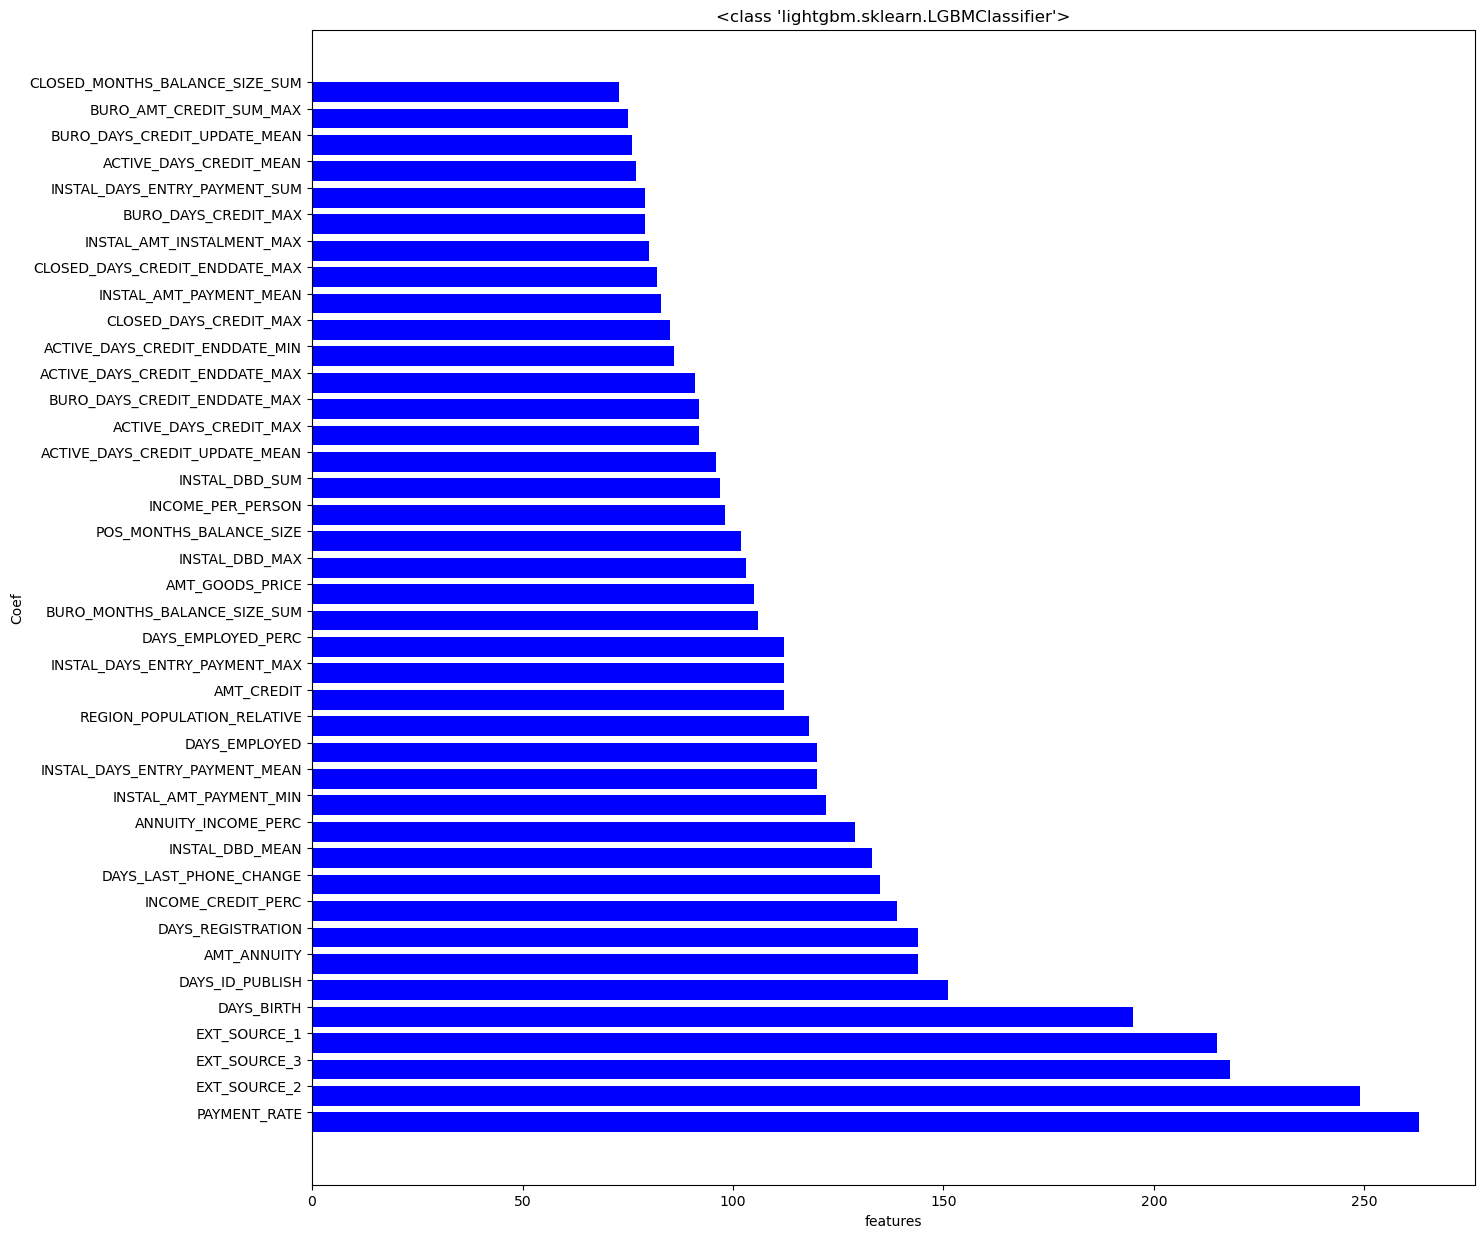

In [26]:
# Selection of important features :

import joblib
num_features = 10 
features=[]

# Get features :
#df_dropped=df.drop(['index'], axis=1, inplace= False) # 'TARGET','SK_ID_CURR'

for columns in X.columns: # df_dropped
    features.append(columns)

coefficients=Scoring_credit.feature_importances_  # ( XGB, RFC, )

df_imp_features = pd.DataFrame({"features":features}).join(pd.DataFrame({"weights":coefficients}))
df_imp_features_top40=df_imp_features.sort_values(by=['weights'], ascending=False).head(40) 

coefficients_top40=df_imp_features_top40['weights']
features_top40=df_imp_features_top40['features']

fig, ax = plt.subplots(1,1,figsize=(15,15))    
width = 0.75 # the width of the bars 
ind = np.arange(len(coefficients_top40))  # the x locations for the groups
ax.barh(ind, coefficients_top40, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(features_top40, minor=False)
plt.title(LGBMClassifier)
plt.xlabel('features')
plt.ylabel('Coef')      
df_imp_features_top40 = pd.DataFrame({"features":features_top40}).join(pd.DataFrame({"weights":coefficients_top40}))
df_imp_features_top40.sort_values(by=['weights'], ascending=False) 

## Local Explanations with : LIME Analysis :

L’algorithme LIME (en anglais, Local Interpretable Model-agnostic Explanations) est un modèle local qui cherche à expliquer la prédiction d’un individu par analyse de son voisinage.

LIME a la particularité d’être un modèle :

Interprétable. Il fournit une compréhension qualitative entre les variables d'entrée et la réponse. Les relations entrées-sortie sont faciles à comprendre.

Simple localement. Le modèle est globalement complexe, il faut alors chercher des réponses localement plus simples.

Agnostique. Il est capable d'expliquer n'importe quel modèle de machine learning.

Pour ce faire :

1ère étape : l’algorithme LIME génère des nouvelles données, dans un voisinage proche de l’individu à expliquer.

2ème étape : LIME entraîne un modèle transparent sur les prédictions du modèle « boîte noire » complexe qu’on cherche à interpréter. Il apprend ainsi à l’aide d’un modèle simple et donc interprétable (par exemple, une régression linéaire ou un arbre de décision).

Le modèle transparent joue donc le rôle de modèle de substitut pour interpréter les résultats du modèle complexe d’origine.

In [28]:
pip install lime

     -------------------------------------- 275.7/275.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=66f726e6c44df990a02524e11fc80e9f2a892d0ec197e35f51b161e0e5c85dce
  Stored in directory: c:\users\laure\appdata\local\pip\cache\wheels\6e\ad\de\6e1f2abd50acd8aa9a4c6f2a5201cc8700099ce184922e8724
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [29]:
import lime
import random
from lime import lime_tabular

In [30]:
with open('threshold_model.pkl', 'rb') as file:
    threshold_model=joblib.load(file)

In [31]:
predict_LGBM=lambda x: Scoring_credit.predict_proba(x).astype(float)
num=5000

loan_default_proba=((predict_LGBM(X.iloc[[num]])[0:1][0][1])*100).round(2)   # X_test_2

if y_test_2.iloc[[num]].values[0]==0:
    real_class="0 = Accepted"
elif y_test_2.iloc[[num]].values[0]==1:
    real_class="1 = Refused"

if loan_default_proba>= threshold_model*100:
    predicted_class="1 = refused"
elif loan_default_proba< threshold_model*100:
    predicted_class="0 = Accepted"

print("                                           customer ID = ",X_id[num])
#print("                                           Threshold Model = ",threshold_model.round(2))
#print("                                           Threshold customer = ",thresholds[num].round(2))
print("                      ===================================================================")
print("                      predicted classe :",predicted_class)
print("                      loan default probability =",loan_default_proba," %")
print("")
print("")

#X=X_train_2.values

# Create new explainer
LIM_explainer = lime_tabular.LimeTabularExplainer(X.values, mode="classification", feature_names= features, class_names = ['0 = Accepted','1 = refused'])
LIM_explainer

# Select an observation and create an explanation for it 
observation=X.iloc[[num]].values[0]   # observation=X_test_2.iloc[[num]].values[0]
explanation = LIM_explainer.explain_instance(observation, predict_LGBM, num_features=15)# len(features_top40)

# use "show_in_notebook" method on explanation to visualise results
explanation.show_in_notebook(show_all=False)

                                           customer ID =  105850
                      predicted classe : 1 = refused
                      loan default probability = 78.4  %




In [32]:
from IPython.display import HTML

html_data = explanation.as_html()
HTML(data=html_data)

### SHAP analysis :
Les valeurs de Shapley calculent l’importance d’une variable en comparant ce qu’un modèle prédit avec et sans cette variable. Cependant, étant donné que l’ordre dans lequel un modèle voit les variables peut affecter ses prédictions, cela se fait dans tous les ordres possibles, afin que les fonctionnalités soient comparées équitablement. Cette approche est inspirée de la théorie des jeux.

Pour ce faire :

1ère étape de calcul des valeurs de Shapley pour un individu en particulier : simuler différentes combinaisons de valeurs pour les variables d’entrée

2ème étape : Pour chaque combinaison, calculer la différence entre la valeur prédite et la moyenne des prédictions. La valeur de Shapley d’une variable correspond alors à la moyenne de la contribution de sa valeur en fonction des différentes combinaisons.

Dans un premier temps, nous devrons créer un objet explicatif afin de tracer divers graphiques expliquant une prédiction particulière. Nous allons commencer par créer "Explainer" ce qui est couramment utilisé pour le modèle linéaire

Ci-dessous, nous avons créé "Explainer" en donnant les données du modèle et de train en entrée. Cela créera un explicateur qui ne prend pas en compte la relation entre les variables compte tenu de la corrélation entre les variables.

In [33]:
import shap
shap.initjs()
# creating the TreeExplainer with our model as argument
explainer = shap.TreeExplainer(Scoring_credit) # X_train_2.sample(1000)
# calculating the shap values from our model using some observations 
shap_vals = explainer.shap_values(X) # X = observations      .sample(1000)   X_test_2
# use SHAP visualisation functions with our shap_values
# => shap.summary_plot(shap_values) # Global features importance  

In [34]:
# Sauvegarde du seuil
joblib.dump(shap_vals, 'shap_vals.pkl')

explainer.expected_value
# Expected values save
joblib.dump(explainer.expected_value, 'expected_values.pkl')

['expected_values.pkl']

# Global features importance  

In [35]:
def sample_feature_importance(idx, type='forceplot'):
    if type=='forceplot':
        return shap.force_plot(explainer.expected_value[1],shap_vals[1][idx],feature_names=features)
    elif type=='waterfall':
        return shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_vals[1][idx],max_display=20, feature_names=features)
    elif type=='summaryplot_global':
        return shap.summary_plot(shap_vals[1], features=X_test_2, feature_names=features) # .sample(1000)
    else:
        return "Return valid visual ('condensed', 'waterfall')"

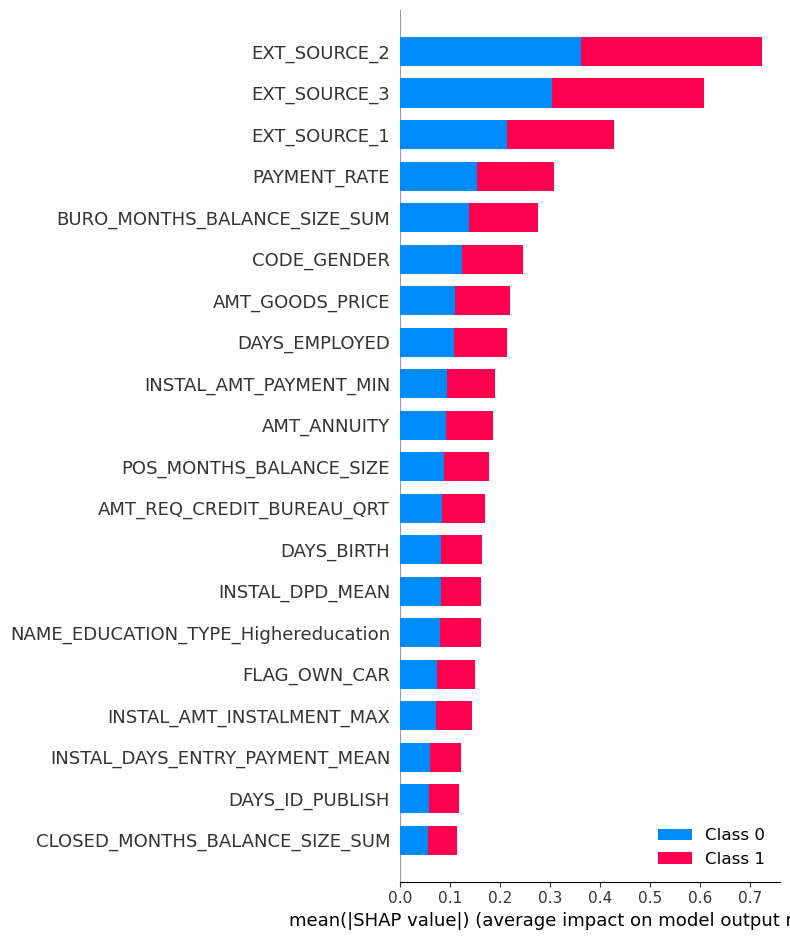

In [36]:
shap.summary_plot(shap_vals, feature_names=features)

# summary Plot

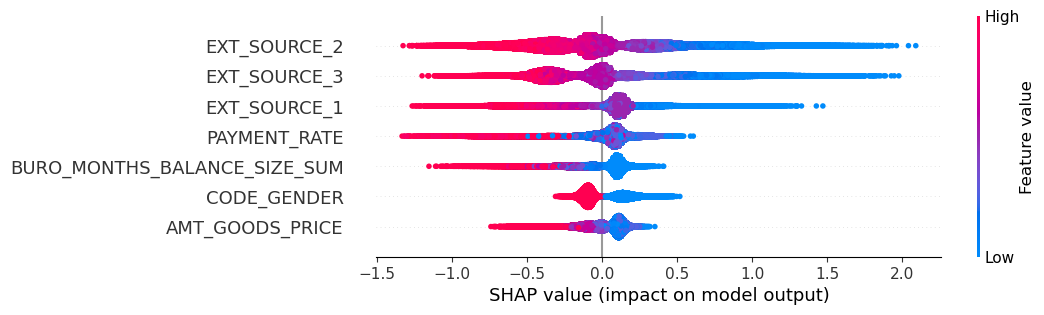

In [37]:
shap.summary_plot(shap_vals[1], # shap values
                  X, # data (np.array)
                  feature_names=features, # features name of data (order matters)
                  max_display=7, # nb of displayed features
                  show=False, # enables setting of plot size later using matplotlib
#                   plot_type="dot",
                      color=plt.get_cmap("tab10"),
                 ) 
# Change size of the figure
plt.gcf().set_size_inches((14,3))

# # Change the colormap of the artists
# my_cmap = plt.get_cmap('seismic')
# for fc in plt.gcf().get_children():
#     for fcc in fc.get_children():
#         if hasattr(fcc, "set_cmap"):
#             fcc.set_cmap(my_cmap)
plt.show()

# Visualisations d’explications d’une instance :

### Force Plot

In [38]:
sample_feature_importance(0, type='forceplot')

### Waterfall Plot :

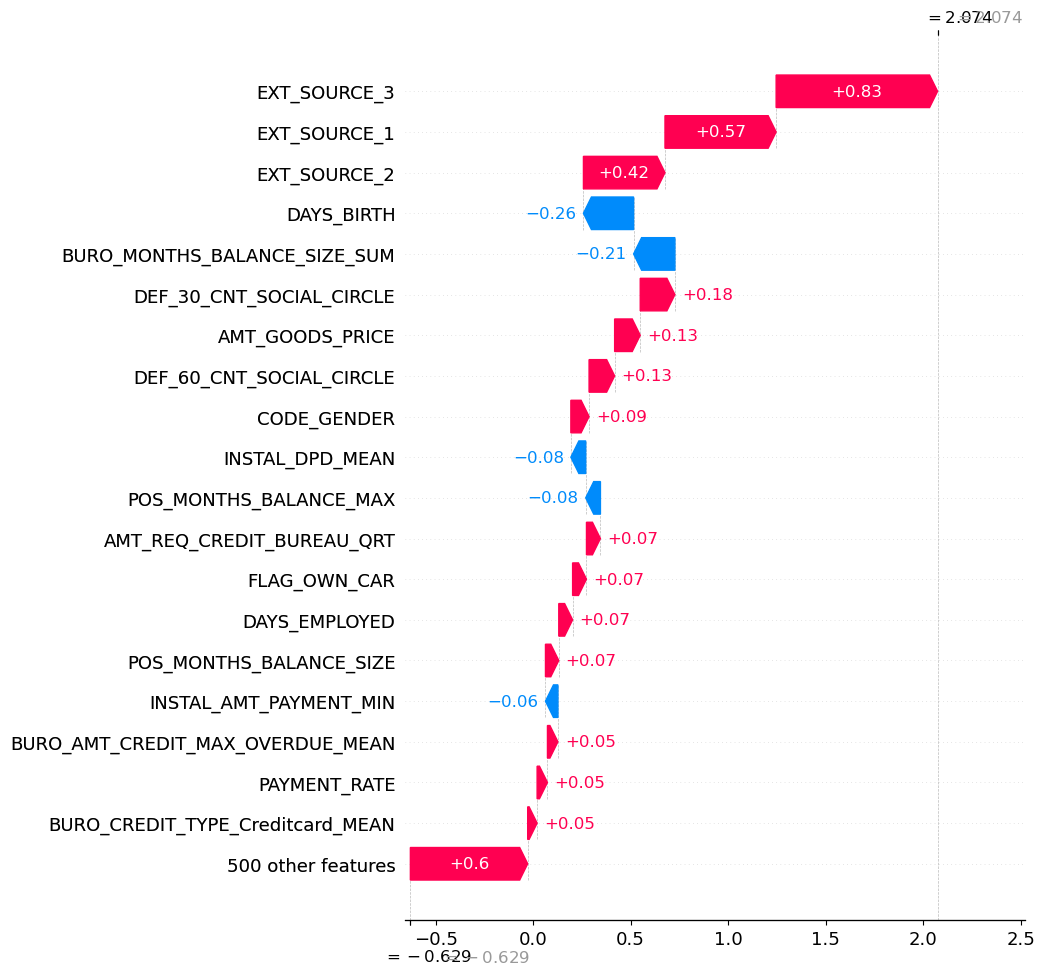

In [39]:
sample_feature_importance(0, type='waterfall')

Explication d’impact des variables pour un exemple du dataset. En rouge, les variables qui ont un impact positif (contribuent à ce que la prédiction soit plus élevée que la valeur de base) et, en bleu, celles ayant un impact négatif (contribuent à ce que la prédiction soit plus basse que la valeur de base)

### Decision Plot :  Comment le modèle arrive à la décision ???

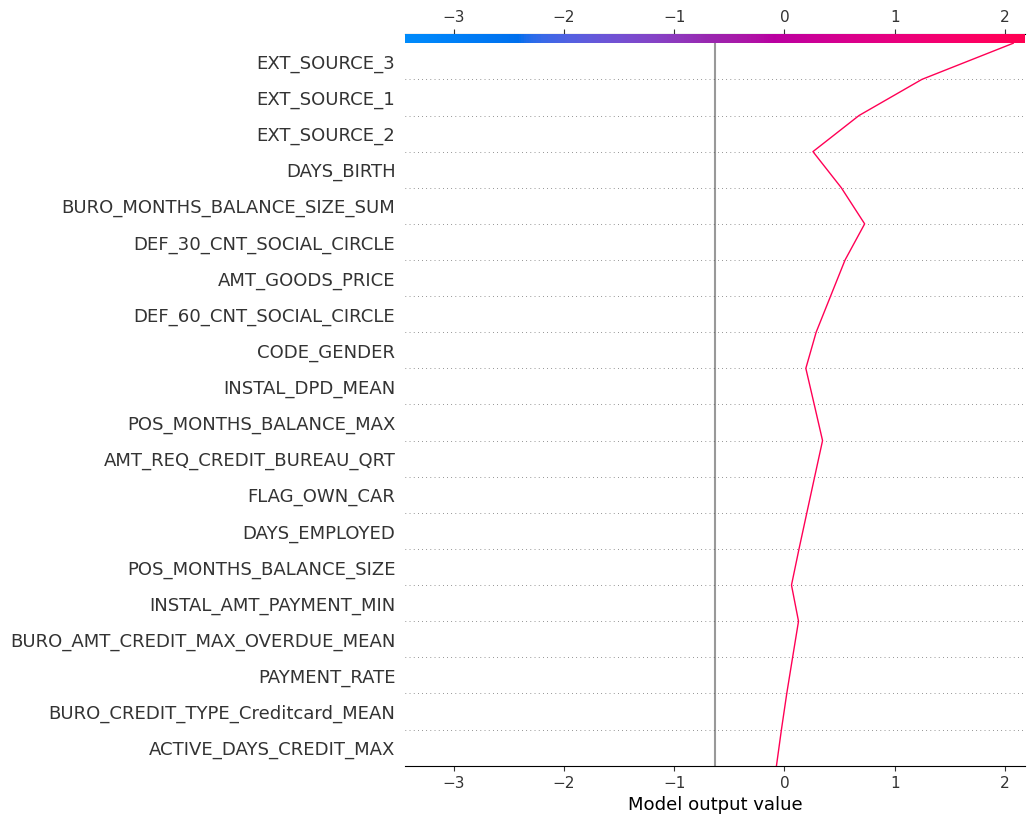

In [40]:
# 1er explicateur :
shap.decision_plot(explainer.expected_value[1],    # La valeur de référence (Valeur prédite sans aucune variable connue)
                   shap_vals[1][0],
                   feature_names=features
                   )